# Business Case: Jamboree Education - Linear Regression

### About Jamboree Education

Jamboree has helped thousands of students like you make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.

They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.

### Buiness Problem

Identify the factors that influence graduate admission and help Jamboree Education understand them. Establish a statistical relationship between the key factors. Using the analysis, help them predict one's chances of admission based on the rest of the variables.


Column Profiling

 - Serial No. (Unique row ID)
 - GRE Scores (out of 340)
 - TOEFL Scores (out of 120)
 - University Rating (out of 5)
 - Statement of Purpose (out of 5)
 - Letter of Recommendation Strength (out of 5)
 - Undergraduate GPA (out of 10)
 - Research Experience (either 0 or 1)
 - Chance of Admit (ranging from 0 to 1)

# Overview of the Notebook - Jamboree Education

### EDA

  - **Loading and inspecting the Dataset**
    - Checking Shape of the Dateset , Meaningful Column names
    - Validating Duplicate Records, Checking Missing values
    - Unique values (counts & names) for each Feature
    - Data & Datatype validation
  - **Univariante & Bivariante Analysis**
     - Numerical Variables
     - Categorial variables 
     - Correlation Analysis
     - Handling Multicollinearity
  - **Model Building**
     - Handling Categorical variables using dummies
     - Test & Train Split
     - Rescaling features
     - Train Model
  - **Validate Linear Regression Assumptions**
     - Multicolillinearity check
     - Mean of residuals
     - Linearity of variables
     - Test for Homoscedasticity
     - Normality of residuals
  - **Model Performance Evaluation**
     - Metrics checked - MAE,RMSE,R2,Adj R2
     - Train and Test performances are checked
     - Comments on performance measures
  - **Summary of final recommendations**

### Importing the required libraries or packages for EDA 

In [480]:
#Importing packages
import numpy as np
import pandas as pd

# Importing matplotlib and seaborn for graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [578]:
# Importing modules or packages for linear Regression.

# Train & Test data split
from sklearn.model_selection import train_test_split

#Feture scaling
from sklearn.preprocessing import StandardScaler

# Statsmodel linear regression
import statsmodels.api as sm

# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error

## Utility Functions - Used during Analysis

### Missing Value - Calculator

In [482]:
def missingValue(df):
    #Identifying Missing data. Already verified above. To be sure again checking.
    total_null = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
    print("Total records = ", df.shape[0])

    md = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
    return md

### Categorical Variable Analysis 
  - Bar plot - Frequency of feature in percentage
  - Pie Chart

In [483]:
# Frequency of each feature in percentage.
def cat_analysis(df, colnames, nrows=2,mcols=2,width=20,height=30, sortbyindex=False):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))  
    fig.set_facecolor(color = 'lightgrey')
    string = "Frequency of "
    rows = 0                          
    for colname in colnames:
        count = (df[colname].value_counts(normalize=True)*100)
        string += colname + ' in (%)'
        if sortbyindex:
                count = count.sort_index()
        count.plot.bar(color=sns.color_palette("bone"),ax=ax[rows][0])
        ax[rows][0].set_ylabel(string, fontsize=14,family = "Comic Sans MS")
        ax[rows][0].set_xlabel(colname, fontsize=14,family = "Comic Sans MS")      
        count.plot.pie(colors = sns.color_palette("copper"),autopct='%0.0f%%',
                       textprops={'fontsize': 14,'family':"Comic Sans MS",'color':'white'},ax=ax[rows][1])        
        string = "Frequency of "
        rows += 1

### Function for Outlier detection
  - Box plot - for checking range of outliers
  - distplot - For checking skewness

In [484]:
def outlier_detect(df,colname,nrows=2,mcols=2,width=20,height=15):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))
    fig.set_facecolor("lightgrey")
    rows = 0
    for var in colname:        
        ax[rows][0].set_title("Boxplot for Outlier Detection ", fontweight="bold")
        plt.ylabel(var, fontsize=12,family = "Comic Sans MS")
        sns.boxplot(y = df[var],color='b',ax=ax[rows][0])
        
        # plt.subplot(nrows,mcols,pltcounter+1)
        sns.distplot(df[var],color='y',ax=ax[rows][1])
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label="Mean")
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label="Median")
        ax[rows][1].axvline(df[var].mode()[0], color='royalblue', linestyle='-', label="Mode")
        ax[rows][1].set_title("Outlier Detection ", fontweight="bold")
        ax[rows][1].legend({'Mean':df[var].mean(),'Median':df[var].median(),'Mode':df[var].mode()})
        rows += 1
    plt.show()

### Boxplot for Categorical variables

In [485]:
#Function to plot a list of categorical variables together
def box_plot(colname,y):
    fig = plt.figure(figsize=(18, 14))
    fig.set_facecolor("darkgrey")
    for var in colname:
        plt.subplot(2,2,colname.index(var)+1)
        sns.boxplot(x = var, y = y, data = edu_data)
        plt.title("Box plot of " + var, fontweight="bold")
    plt.show()

### Function to calculate the VIF score

In [486]:
# Calculate the VIFs for the new model
def getVIF(X_train):
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

## Exploratory Data Analysis

### Loading and inspecting the Dataset

#### Loading the csv file

In [487]:
edu_data = pd.read_csv("./Jamboree_Admission.csv")

In [488]:
edu_data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


#### Checking Shape and Column names

In [489]:
edu_data.shape

(500, 9)

In [490]:
edu_data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

### Removing unwanted column from the dataset

In [491]:
edu_data.drop(columns=['Serial No.'],inplace=True)

### Renaming columns - Removing extra whitespace "LOR " & "Chance of Admit ".

In [492]:
edu_data.rename(columns={"LOR ": "LOR", "Chance of Admit ": "Chance of Admit"}, inplace=True)

#### Validating Duplicate Records

In [493]:
edu_data.duplicated().sum()

0

### Inference
  - No dupicates records found.

### Missing Data Analysis

In [494]:
missingValue(edu_data).head(5)

Total records =  500


,Total Missing,In Percent
GRE Score,0,0.0
TOEFL Score,0,0.0
University Rating,0,0.0
SOP,0,0.0
LOR,0,0.0


### Inference
  - No missing value found.

### Unique values (counts) for each Feature

In [495]:
edu_data.nunique()

GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

### Unique values are checked

In [496]:
edu_data['Research'].unique()

array([1, 0], dtype=int64)

### Inference 
  - Research and University rating are categorical variables

### DataType Validation

In [497]:
edu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [498]:
edu_data['SOP'] = edu_data['SOP'].astype("category")
edu_data['LOR'] = edu_data['LOR'].astype("category")
edu_data['Research'] = edu_data['Research'].astype("category")
edu_data['University Rating'] = edu_data['University Rating'].astype("category")

In [499]:
edu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE Score          500 non-null    int64   
 1   TOEFL Score        500 non-null    int64   
 2   University Rating  500 non-null    category
 3   SOP                500 non-null    category
 4   LOR                500 non-null    category
 5   CGPA               500 non-null    float64 
 6   Research           500 non-null    category
 7   Chance of Admit    500 non-null    float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 18.8 KB


### Statistical Summary 

In [500]:
edu_data.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


In [501]:
edu_data.describe(include=['object','category']).T

,count,unique,top,freq
University Rating,500.0,5.0,3.0,162.0
SOP,500.0,9.0,4.0,89.0
LOR,500.0,9.0,3.0,99.0
Research,500.0,2.0,1.0,280.0


### Numerical Variables - Outlier detection
 - GRE Score
 - TOEFL Score
 - CGPA

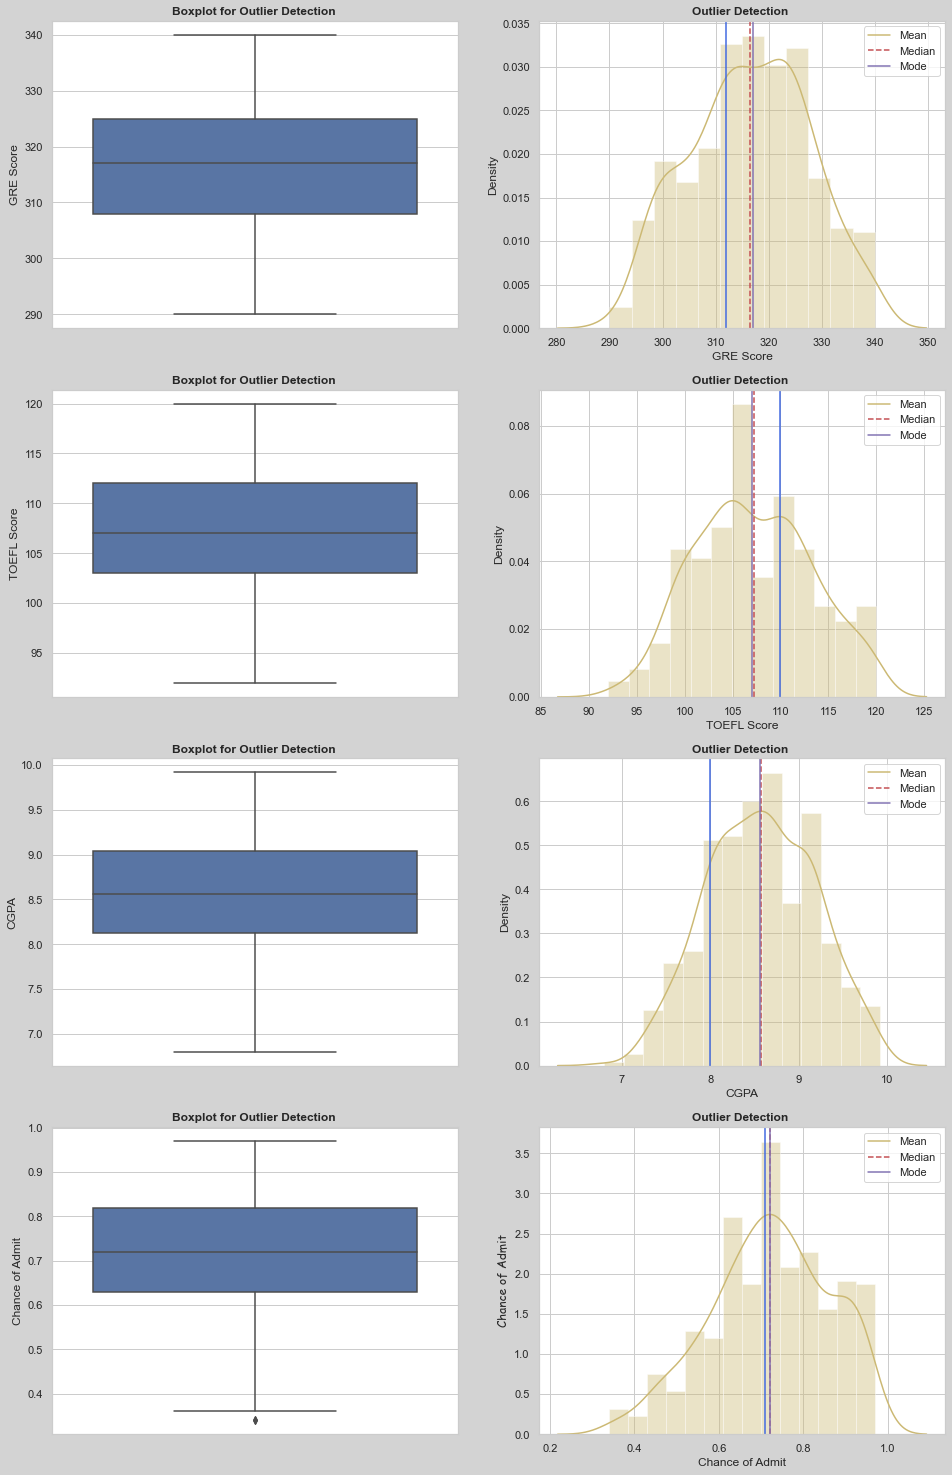

In [502]:
# ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP','LOR ', 'CGPA', 'Research', 'Chance of Admit ']
col_num = [ 'GRE Score', 'TOEFL Score', 'CGPA','Chance of Admit']
outlier_detect(edu_data,col_num,4,2,16,26)

### Inferences
 - Based on the above graph we donot have outliers for "'GRE Score', 'TOEFL Score' & 'CGPA'.
 - 'Chance of Admit' is slightly left screwed. Since 'Chance of Admit' is a slightly left skewed, we don't have to handle it.
 

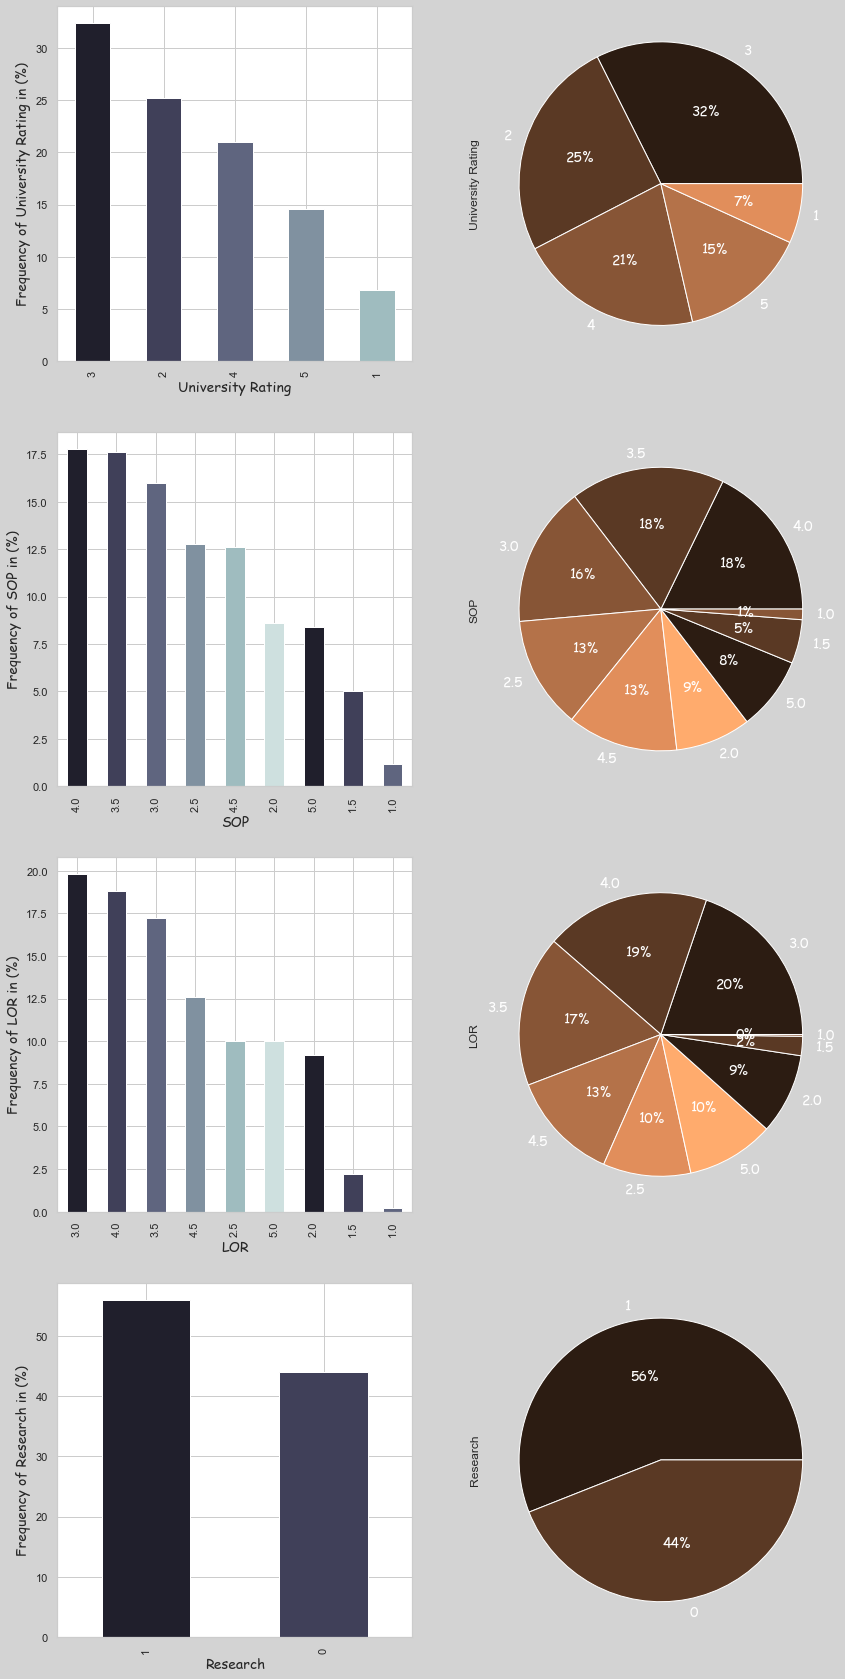

In [503]:
# ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP','LOR ', 'CGPA', 'Research', 'Chance of Admit ']
cat_cols = ['University Rating', 'SOP','LOR', 'Research']
cat_analysis(edu_data,cat_cols,4,2,14,30)

### Inferences 
- Among students who have done research vs those who did not, 56 % said yes and 44 % said no
- More than 50% of the data has a university rating of 3 or 2
- A majority of students (56%) have letter of recommendation values between 3.0 and 4.5

## Bivariate Analysis 

#### Numerical variables
 - 'GRE Score' vs 'Chance of Admit'
 - 'TOEFL Score' vs 'Chance of Admit'
 - 'CGPA' vs 'Chance of Admit'

#### Categorical variables
 - 'Research' vs 'Chance of Admit'
 - 'Univarsity rating' vs 'Chance of Admit'
 - 'LOR' vs 'Chance of Admit'
 - 'SOP' vs 'Chance of Admit'

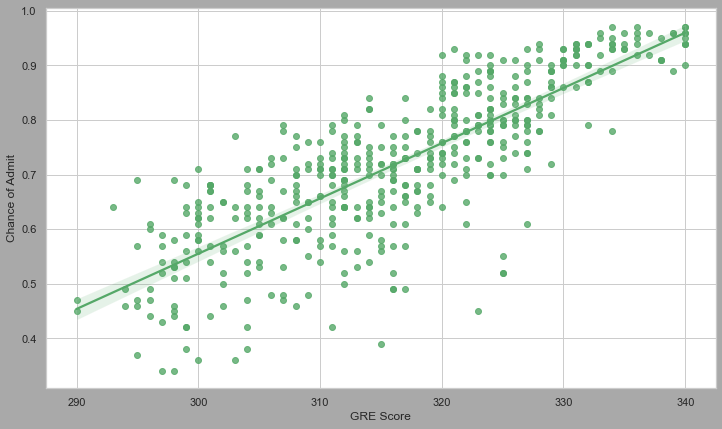

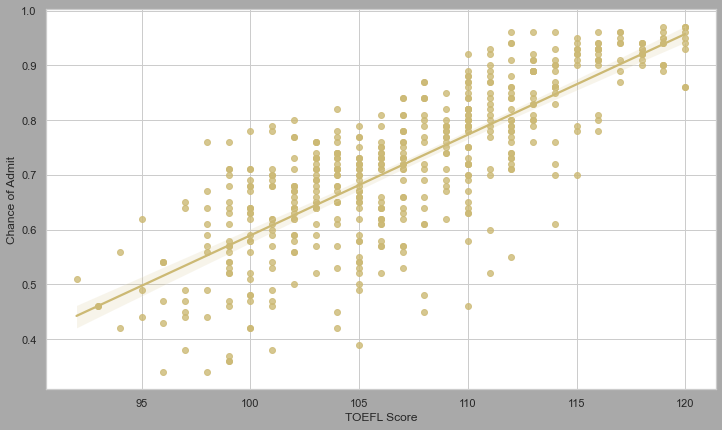

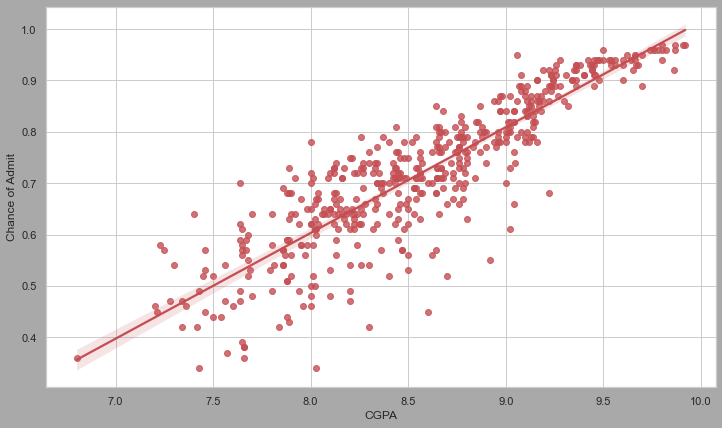

In [504]:
fig = plt.figure(figsize=(12, 7))
fig.set_facecolor(color = 'darkgrey')
sns.regplot(x='GRE Score',y='Chance of Admit',color="g",data=edu_data);

fig = plt.figure(figsize=(12, 7))
fig.set_facecolor(color = 'darkgrey')
sns.regplot(x='TOEFL Score',y='Chance of Admit',color="y",data=edu_data);

fig = plt.figure(figsize=(12, 7))
fig.set_facecolor(color = 'darkgrey')
sns.regplot(x='CGPA',y='Chance of Admit',color="r",data=edu_data);


### Inferences 
 - A strong positive relationship exists between Chance of admit and numerical variables (GRE & TOEFL score and CGPA).

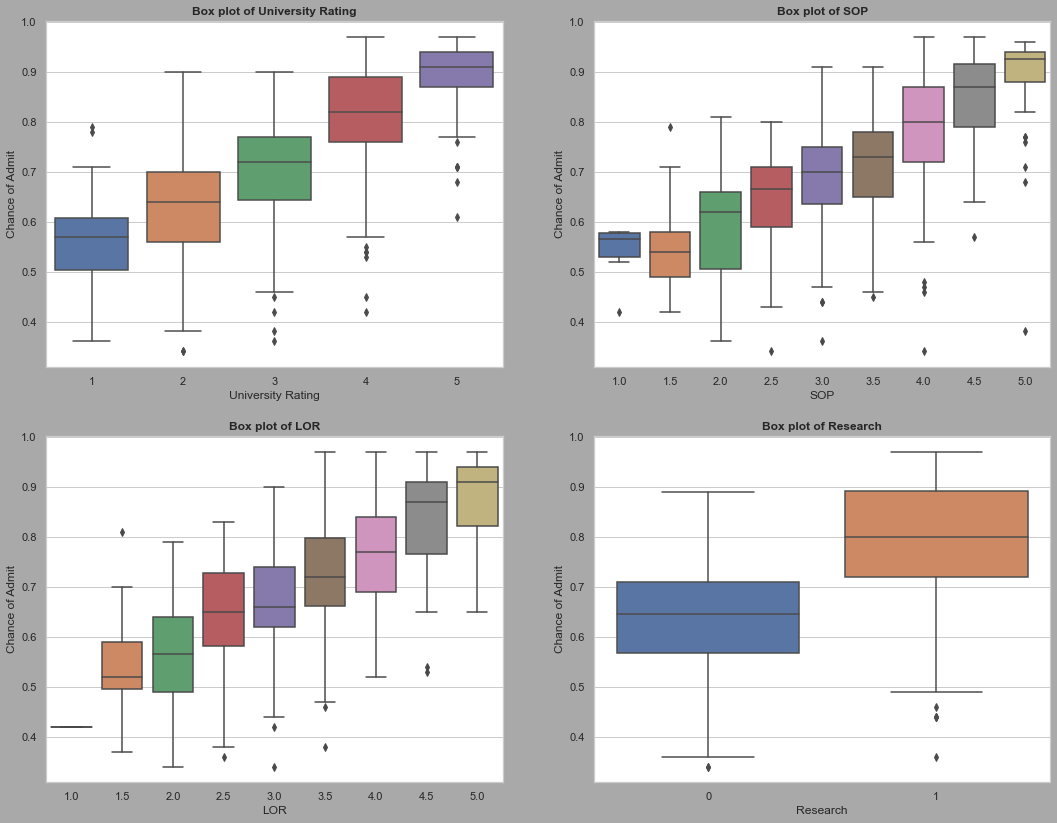

In [505]:
box_plot(['University Rating', 'SOP', 'LOR','Research'],'Chance of Admit')

### Inferences
 - The graph above shows an upward trend for each categorical variable. A higher rating or value increases the chance of admission

## Correlation Analysis

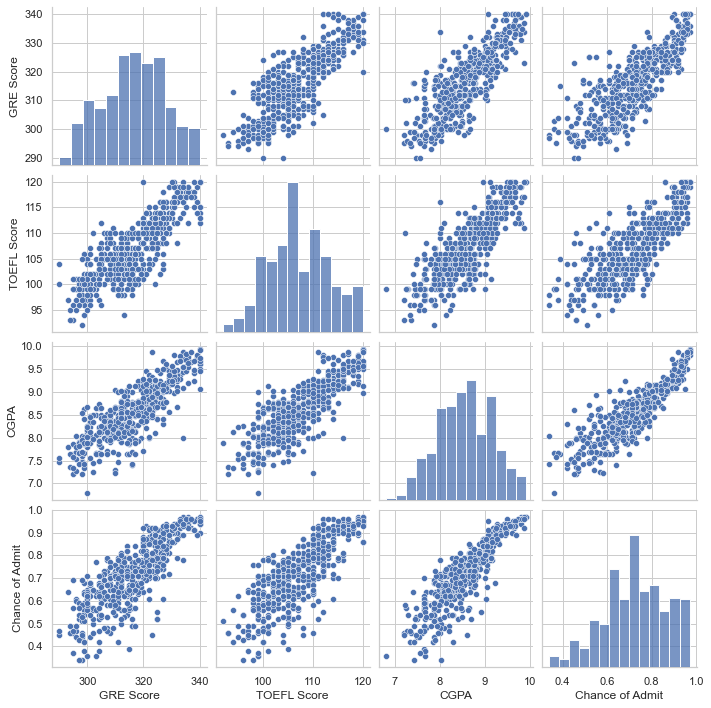

In [506]:
sns.pairplot(edu_data)

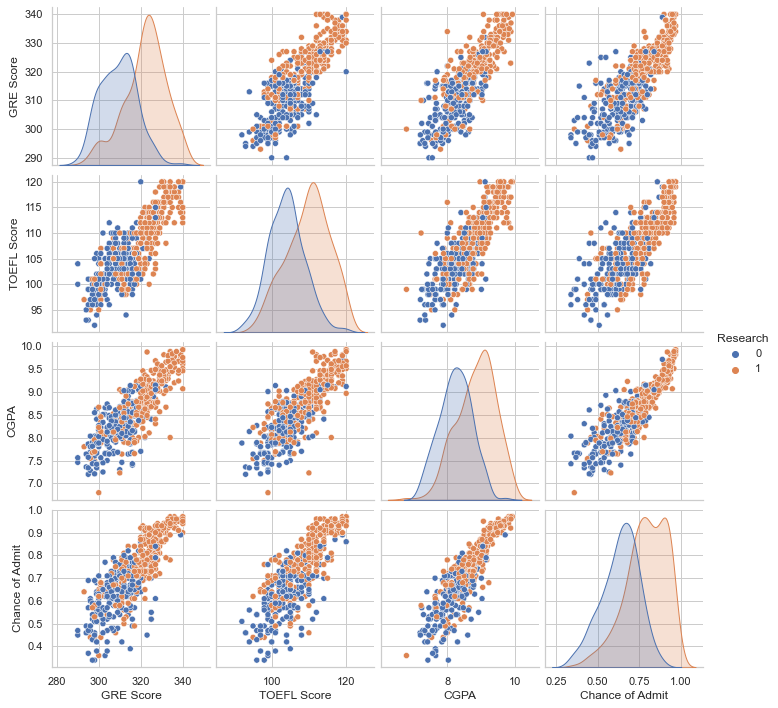

In [507]:
sns.pairplot(edu_data,hue='Research')

### Inferences 
 - We can see positive relationship between Chance of Admit & all the numerical variables.

## Check on multicolienarity.

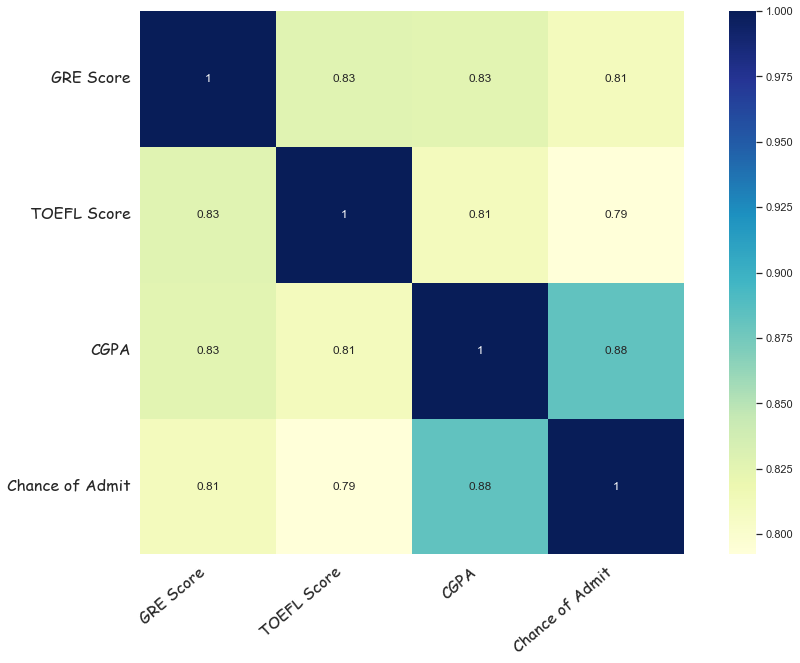

In [508]:
plt.figure(figsize = (16, 10))
ax = sns.heatmap(edu_data.corr(),
            annot=True,cmap='YlGnBu',square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,fontsize=16,family = "Comic Sans MS",
    horizontalalignment='right')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,fontsize=16,family = "Comic Sans MS",
    horizontalalignment='right')
    
plt.show()

## Inferences

#### We can already see some multicolinearity between the independent variables.

- **GRE Score** , **TOFEL Score** and **CGPA** are highly correlated **(0.80)**. We should drop two of these.

In [509]:
edu_data.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

### Considered only Significant variables 
 - When multiple features are highly correlated (above 0.80), only one feature is considered

In [510]:
# Creating the new dataframe with only significant variables.
significant_colname = ['GRE Score', 'University Rating', 'SOP', 'LOR', 'Research', 'Chance of Admit']
sig_edu_data = edu_data[significant_colname]
sig_edu_data.shape

(500, 6)

## Handling Categorical variable for Linear Regression
 - Used pandas Dummies to covert categorical variables to Numerical variables

In [511]:
significant_cat_colname = ['University Rating','SOP','LOR']

# Creating dummy variables for 'Cars_Category','enginetype','carbody','cylindernumber', 'drivewheel'
dummyVar = pd.get_dummies(sig_edu_data[significant_cat_colname],drop_first=True)
dummyVar.shape

(500, 20)

In [512]:
dummyVar.head()

,University Rating_2,University Rating_3,University Rating_4,University Rating_5,SOP_1.5,SOP_2.0,SOP_2.5,SOP_3.0,SOP_3.5,SOP_4.0,SOP_4.5,SOP_5.0,LOR_1.5,LOR_2.0,LOR_2.5,LOR_3.0,LOR_3.5,LOR_4.0,LOR_4.5,LOR_5.0
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [513]:
# Merging the dummy variable to significant variable dataframe.
sig_edu_data = pd.concat([sig_edu_data,dummyVar],axis=1)
sig_edu_data.shape

(500, 26)

In [514]:
# Dropping origincal Categorical variables as no need. Already added them as numerical.
sig_edu_data.drop(significant_cat_colname,axis=1,inplace=True)
sig_edu_data.shape

(500, 23)

## Splitting the Data into Training and Testing Sets

In [515]:
# Splitting the avilable data into training and testing set with 70:30 ratio (train:test)
df_train, df_test = train_test_split(sig_edu_data, train_size = 0.7, random_state = 100)
print(df_train.shape)
print(df_test.shape)

(350, 23)
(150, 23)


In [516]:
sig_edu_data.head()

,GRE Score,Research,Chance of Admit,University Rating_2,University Rating_3,University Rating_4,University Rating_5,SOP_1.5,SOP_2.0,SOP_2.5,...,SOP_4.5,SOP_5.0,LOR_1.5,LOR_2.0,LOR_2.5,LOR_3.0,LOR_3.5,LOR_4.0,LOR_4.5,LOR_5.0
0,337,1,0.92,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,324,1,0.76,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,316,1,0.72,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,322,1,0.80,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,314,0,0.65,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [517]:
df_train.columns

Index(['GRE Score', 'Research', 'Chance of Admit', 'University Rating_2',
       'University Rating_3', 'University Rating_4', 'University Rating_5',
       'SOP_1.5', 'SOP_2.0', 'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0',
       'SOP_4.5', 'SOP_5.0', 'LOR_1.5', 'LOR_2.0', 'LOR_2.5', 'LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0'],
      dtype='object')

## Rescaling the Features

As per above table, features are varying in different ranges. This will be problem. It is important that we rescale the feature such that thay have a comparable scales.
This can lead us time consuming during model evaluation.

So it is advices to Standardization and normalization so that units of coefficients obtained are in same scale. Two common ways of rescaling are 

1. Standardization (mean-0, sigma-1)
2. Min-Max scaling (Normization)

- We will be using standardization scaling

In [518]:
# Using MinMaxScaler to scale all the numeric variables in the same scale between 0 and 1.
scaler = StandardScaler()

# Apply scaler() to all numerical columns
num_col = ['GRE Score', 'Chance of Admit']

df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_train.head()

,GRE Score,Research,Chance of Admit,University Rating_2,University Rating_3,University Rating_4,University Rating_5,SOP_1.5,SOP_2.0,SOP_2.5,...,SOP_4.5,SOP_5.0,LOR_1.5,LOR_2.0,LOR_2.5,LOR_3.0,LOR_3.5,LOR_4.0,LOR_4.5,LOR_5.0
153,0.664269,0,0.483718,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
84,2.084080,1,1.557510,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
310,0.309316,1,0.268959,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
494,-1.376710,1,-0.303730,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
126,0.575531,1,0.913235,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [519]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,350.0,-1.711647e-15,1.001432,-2.352830,-0.755543,-0.045637,0.664269,2.084080
Chance of Admit,350.0,-7.448010e-16,1.001432,-2.737658,-0.661660,-0.017385,0.698476,1.772268
University Rating_2,350.0,2.542857e-01,0.436082,0.000000,0.000000,0.000000,1.000000,1.000000
University Rating_3,350.0,3.142857e-01,0.464895,0.000000,0.000000,0.000000,1.000000,1.000000
University Rating_4,350.0,2.285714e-01,0.420514,0.000000,0.000000,0.000000,0.000000,1.000000
University Rating_5,350.0,1.342857e-01,0.341447,0.000000,0.000000,0.000000,0.000000,1.000000
SOP_1.5,350.0,4.857143e-02,0.215278,0.000000,0.000000,0.000000,0.000000,1.000000
SOP_2.0,350.0,7.714286e-02,0.267200,0.000000,0.000000,0.000000,0.000000,1.000000
SOP_2.5,350.0,1.285714e-01,0.335204,0.000000,0.000000,0.000000,0.000000,1.000000
SOP_3.0,350.0,1.742857e-01,0.379898,0.000000,0.000000,0.000000,0.000000,1.000000


In [520]:
df_train.columns

Index(['GRE Score', 'Research', 'Chance of Admit', 'University Rating_2',
       'University Rating_3', 'University Rating_4', 'University Rating_5',
       'SOP_1.5', 'SOP_2.0', 'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0',
       'SOP_4.5', 'SOP_5.0', 'LOR_1.5', 'LOR_2.0', 'LOR_2.5', 'LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0'],
      dtype='object')

### Checking the correlation coefficients to see which variables are highly correlated

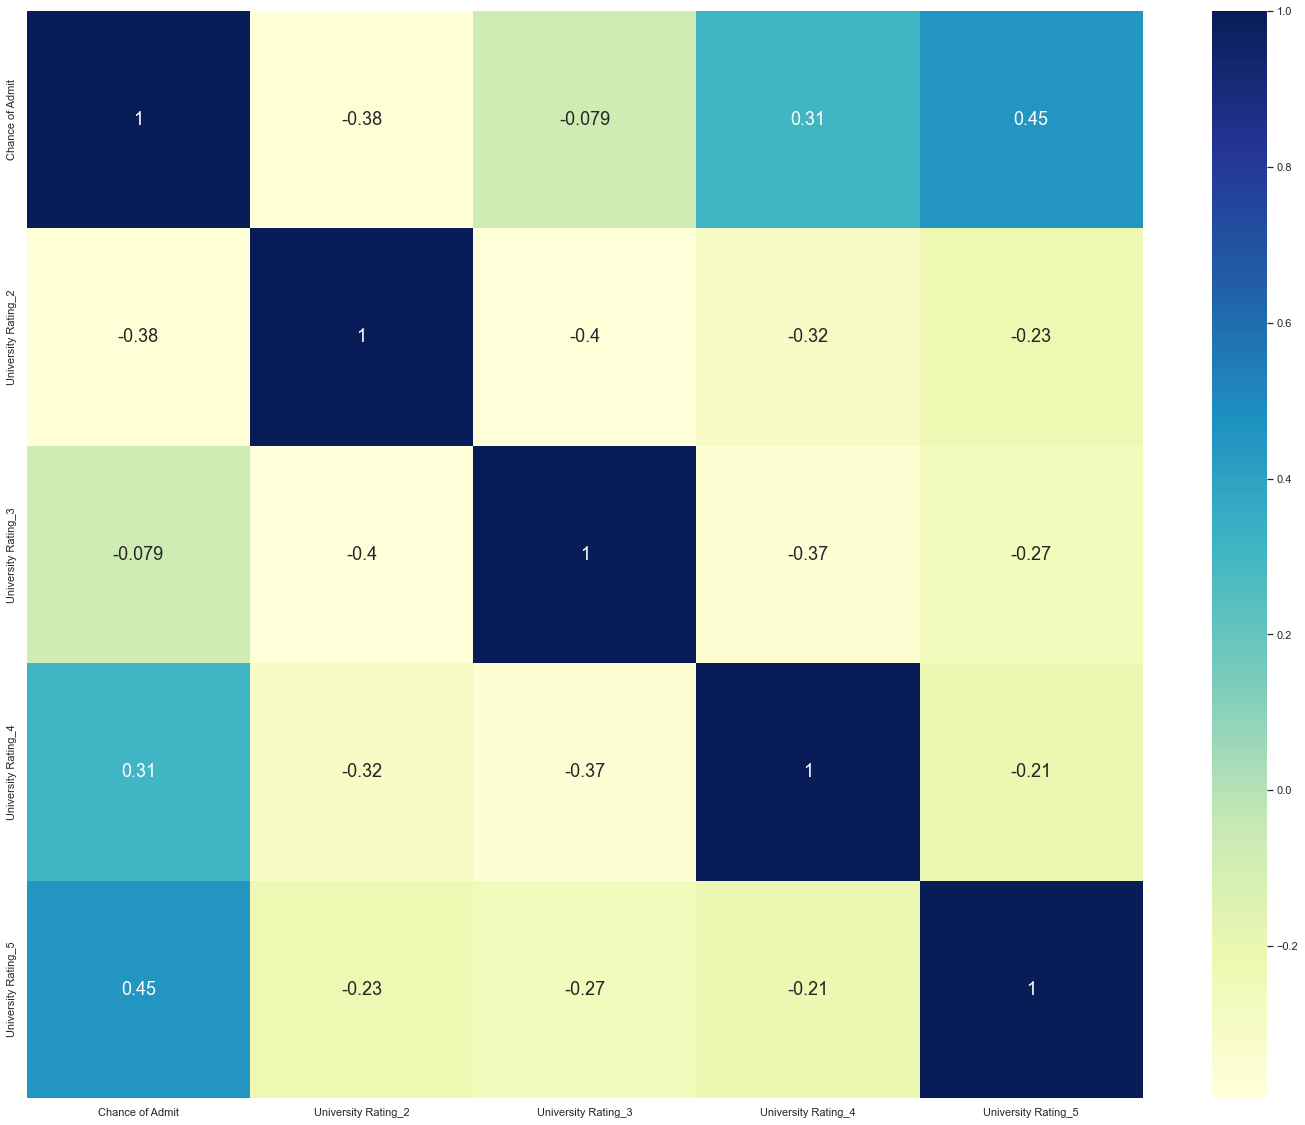

In [521]:
plt.figure(figsize = (25, 20))
data_set1 = df_train[['Chance of Admit', 'University Rating_2',
       'University Rating_3', 'University Rating_4', 'University Rating_5']]
sns.heatmap(data_set1.corr(),annot=True,cmap="YlGnBu",annot_kws={"size": 18})
plt.show()

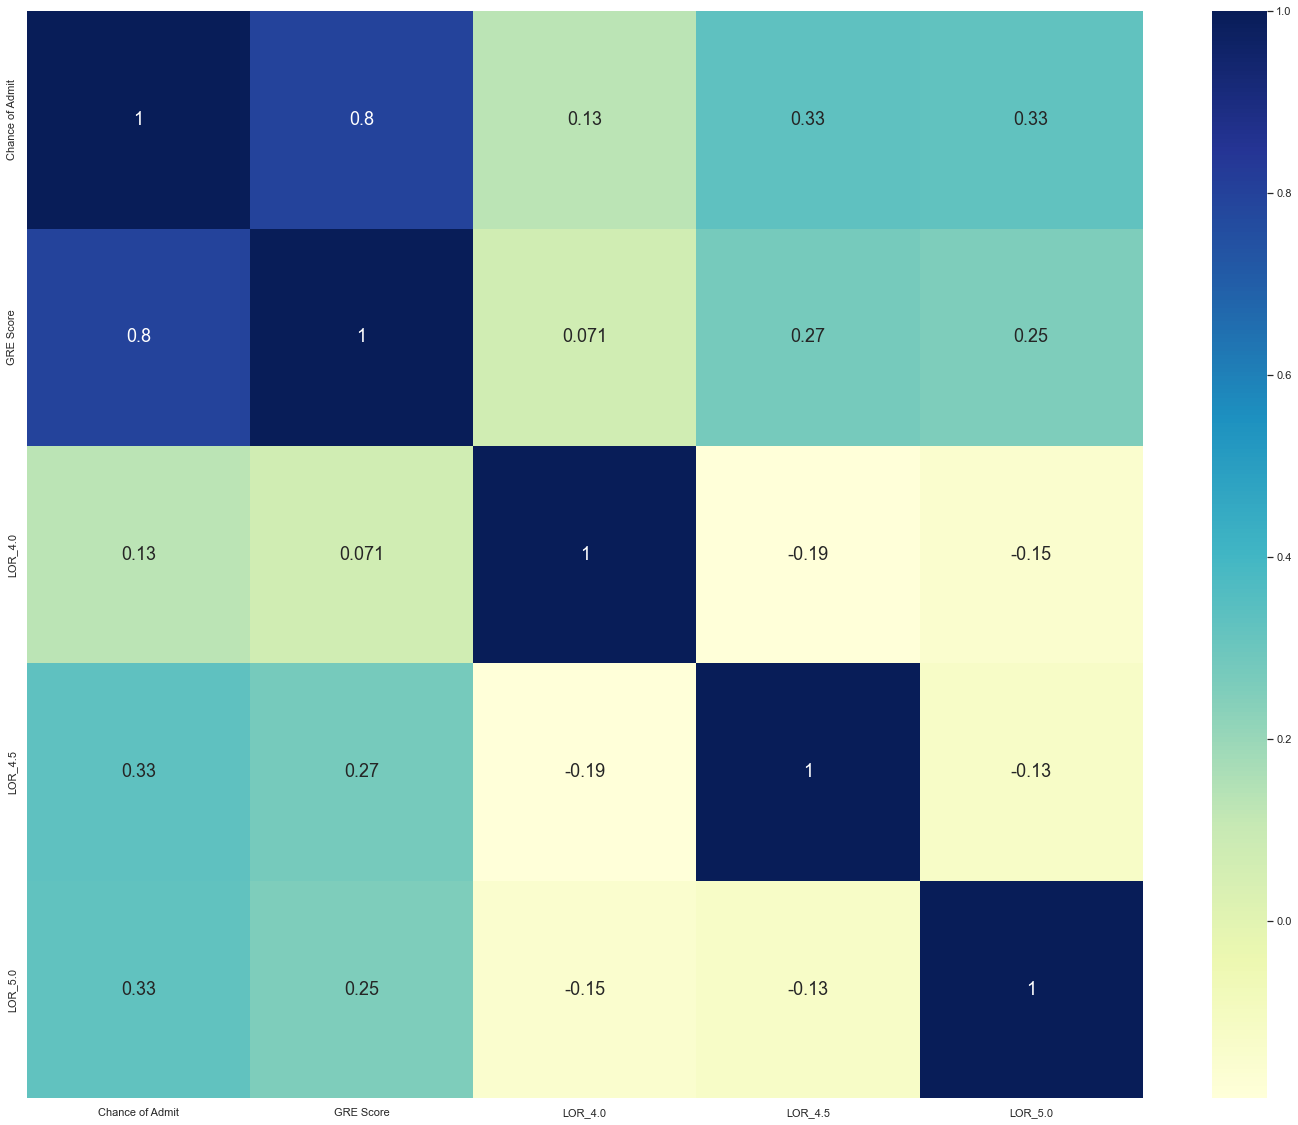

In [522]:
plt.figure(figsize = (25, 20))
data_set1 = df_train[['Chance of Admit','GRE Score', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
sns.heatmap(data_set1.corr(),annot=True,cmap="YlGnBu",annot_kws={"size": 18})
plt.show()

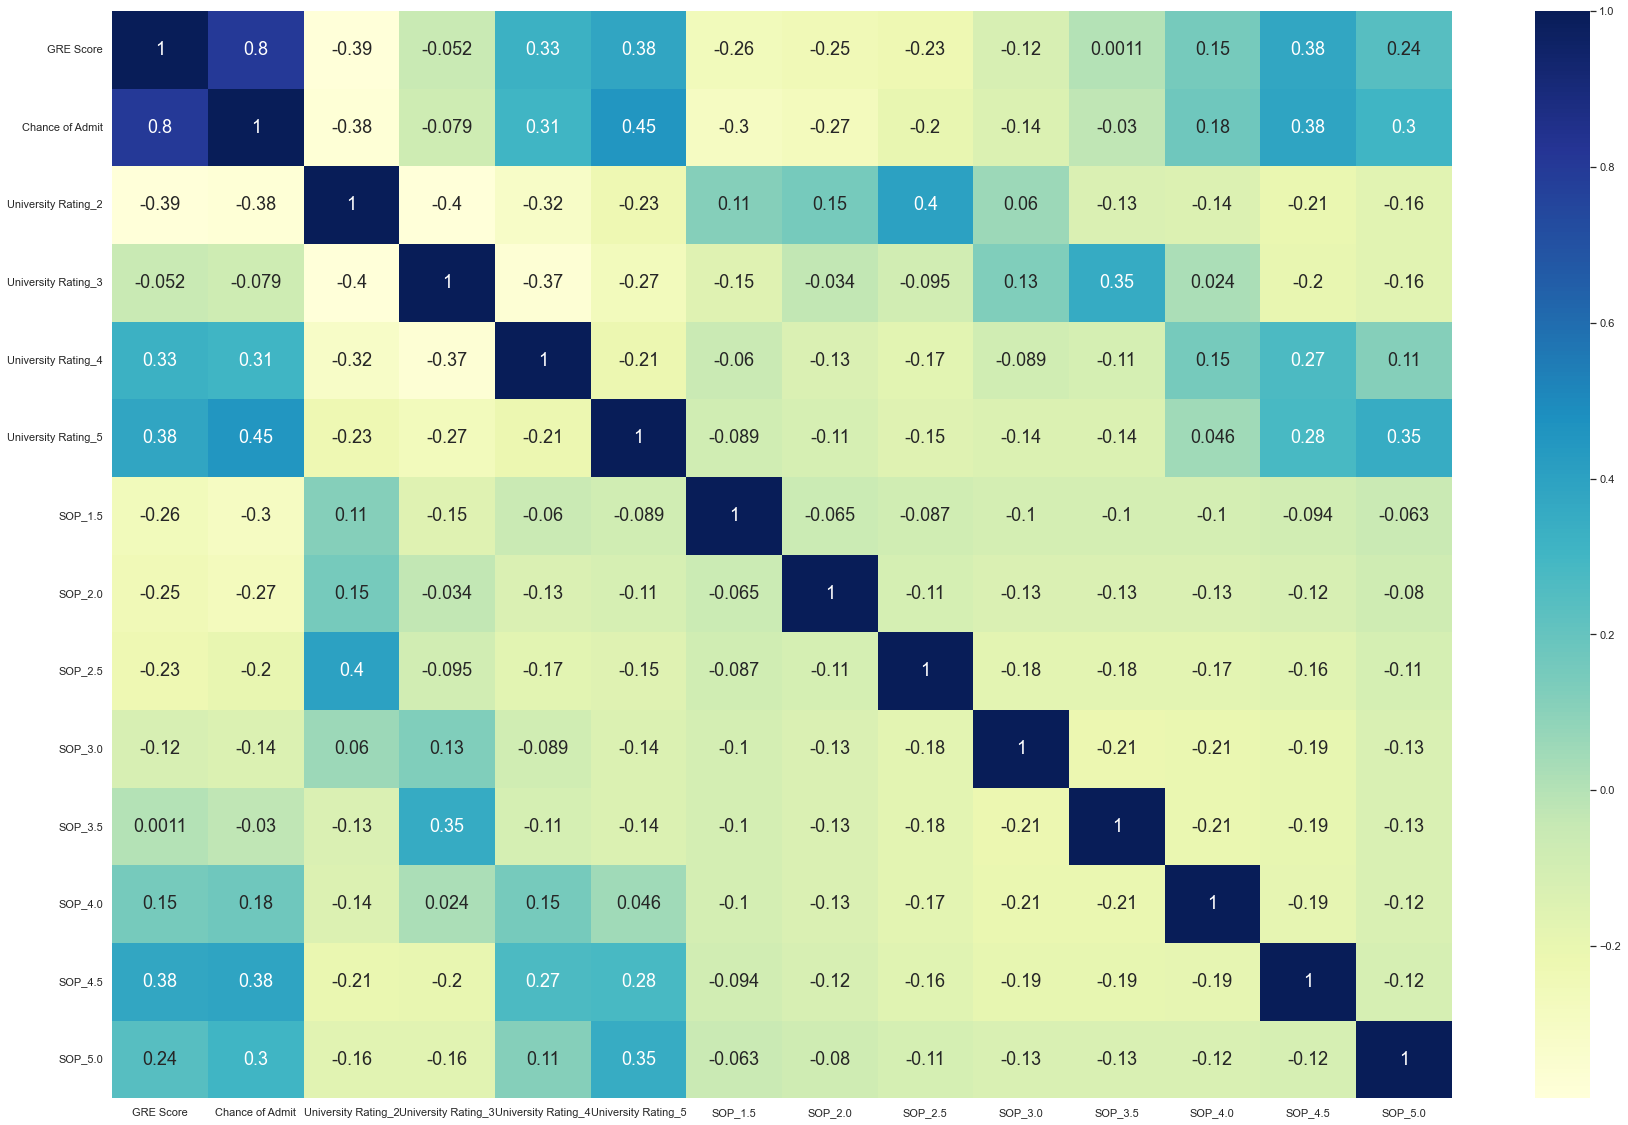

In [523]:
plt.figure(figsize = (30, 20))
data_set1 = df_train[['GRE Score', 'Research', 'Chance of Admit', 'University Rating_2',
       'University Rating_3', 'University Rating_4', 'University Rating_5',
       'SOP_1.5', 'SOP_2.0', 'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0',
       'SOP_4.5', 'SOP_5.0']]
sns.heatmap(data_set1.corr(),annot=True,cmap="YlGnBu",annot_kws={"size": 18})
plt.show()

### Inferences
 - No new features are highly correlated after creating new features using dummies.

# Training the Model

 - Used Backward Elimination for Feature Selection
 
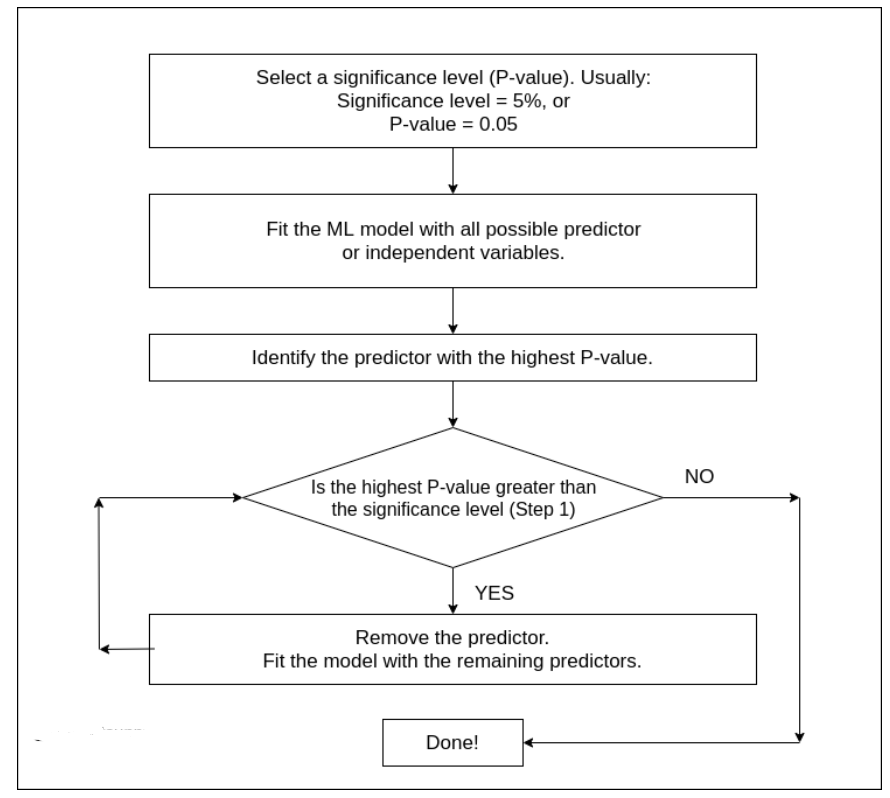

In [524]:
y_train = df_train.pop('Chance of Admit')
X_train = df_train

In [525]:
print(X_train.shape)
print(y_train.shape)

(350, 22)
(350,)


In [526]:
X_train_1 = X_train[['GRE Score', 'Research', 'University Rating_2',
       'University Rating_3', 'University Rating_4', 'University Rating_5',
       'SOP_1.5', 'SOP_2.0', 'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0',
       'SOP_4.5', 'SOP_5.0', 'LOR_1.5', 'LOR_2.0', 'LOR_2.5', 'LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_1 = sm.add_constant(X_train_1)
lr_1 = sm.OLS(y_train, X_train_1).fit()

lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     42.08
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           1.11e-81
Time:                        09:24:18   Log-Likelihood:                -261.59
No. Observations:                 350   AIC:                             569.2
Df Residuals:                     327   BIC:                             657.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3717      0.533     -2.575      0.010      -2.420      -0.324
GRE Score               0.5104      0.043     11.995      0.000       0.427       0.594
Research                0.1533      0.071      2.172      0.031       0.014       0.292
University Rating_2     0.0750      0.138      0.544      0.587      -0.196       0.346
University Rating_3     0.1298      0.146      0.892      0.373      -0.157       0.416
University Rating_4     0.1781      0.163      1.092      0.275      -0.143       0.499
University Rating_5     0.4388      0.181      2.428      0.016       0.083       0.794
SOP_1.5                -0.0281      0.420     -0.067      0.947      -0.855       0.799
SOP_2.0                 0.0947      0.410      0.231      0.818      -0.713       0.902
SOP_2.5                 0.3224      0.416      0.775      0.439      -0.496       1.141
SOP_3.0                 0.2526      0.413      0.612      0.541      -0.560       1.065
SOP_3.5                 0.2819      0.418      0.674      0.501      -0.541       1.104
SOP_4.0                 0.3772      0.421      0.895      0.371      -0.452       1.206
SOP_4.5                 0.4731      0.427      1.107      0.269      -0.368       1.314
SOP_5.0                 0.4953      0.437      1.133      0.258      -0.364       1.355
LOR_1.5                 0.4028      0.658      0.612      0.541      -0.892       1.698
LOR_2.0                 0.4516      0.667      0.677      0.499      -0.861       1.764
LOR_2.5                 0.6710      0.658      1.019      0.309      -0.624       1.966
LOR_3.0                 0.6789      0.663      1.024      0.307      -0.625       1.983
LOR_3.5                 0.7725      0.663      1.165      0.245      -0.532       2.077
LOR_4.0                 0.9193      0.664      1.384      0.167      -0.387       2.226
LOR_4.5                 1.0768      0.667      1.614      0.108      -0.236       2.389
LOR_5.0                 1.1767      0.671      1.754      0.080      -0.143       2.496
==============================================================================
Omnibus:                       56.599   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.858
Skew:                          -0.949   Prob(JB):                     4.16e-21
Kurtosis:                       4.683   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inferences 
- R-Square value is -.739
- Based on the P-values, the following features were removed
  - University rating 2 - 0.587
  - SOP 1.5 - 0.947
  - LOR 1.5 - 0.541

In [527]:
X_train_2 = X_train[['GRE Score', 'Research', 
       'University Rating_3', 'University Rating_4', 'University Rating_5',
       'SOP_2.0', 'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0',
       'SOP_4.5', 'SOP_5.0', 'LOR_2.0', 'LOR_2.5', 'LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_2 = sm.add_constant(X_train_2)
lr_2 = sm.OLS(y_train, X_train_2).fit()

lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     49.01
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           4.93e-84
Time:                        09:24:18   Log-Likelihood:                -262.01
No. Observations:                 350   AIC:                             564.0
Df Residuals:                     330   BIC:                             641.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0296      0.220     -4.686      0.000      -1.462      -0.597
GRE Score               0.5123      0.042     12.105      0.000       0.429       0.596
Research                0.1514      0.070      2.160      0.031       0.014       0.289
University Rating_3     0.0632      0.085      0.745      0.457      -0.104       0.230
University Rating_4     0.1113      0.110      1.009      0.314      -0.106       0.328
University Rating_5     0.3712      0.134      2.765      0.006       0.107       0.635
SOP_2.0                 0.1547      0.160      0.969      0.333      -0.159       0.469
SOP_2.5                 0.3956      0.147      2.688      0.008       0.106       0.685
SOP_3.0                 0.3199      0.151      2.122      0.035       0.023       0.616
SOP_3.5                 0.3478      0.161      2.165      0.031       0.032       0.664
SOP_4.0                 0.4451      0.165      2.697      0.007       0.120       0.770
SOP_4.5                 0.5399      0.179      3.011      0.003       0.187       0.893
SOP_5.0                 0.5624      0.201      2.791      0.006       0.166       0.959
LOR_2.0                 0.1090      0.213      0.511      0.609      -0.310       0.528
LOR_2.5                 0.3347      0.211      1.587      0.114      -0.080       0.750
LOR_3.0                 0.3375      0.203      1.664      0.097      -0.062       0.737
LOR_3.5                 0.4310      0.205      2.099      0.037       0.027       0.835
LOR_4.0                 0.5777      0.209      2.766      0.006       0.167       0.989
LOR_4.5                 0.7351      0.219      3.358      0.001       0.304       1.166
LOR_5.0                 0.8345      0.230      3.631      0.000       0.382       1.287
==============================================================================
Omnibus:                       55.485   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.991
Skew:                          -0.932   Prob(JB):                     1.06e-20
Kurtosis:                       4.683   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inferences
 - No much changes in R-square value after removing 3 - varaibles. (R-square reduced by 0.001)
 - Based on the P-values, the following features were removed
    - University rating 3 - 0.457
    - SOP 2.0 - 0.333
    - LOR 2.0 - 0.609

In [528]:
X_train_3 = X_train[['GRE Score', 'Research','University Rating_4', 'University Rating_5',
       'SOP_2.5', 'SOP_3.0', 'SOP_3.5', 'SOP_4.0','SOP_4.5', 'SOP_5.0', 'LOR_2.5', 'LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_3 = sm.add_constant(X_train_3)
lr_3 = sm.OLS(y_train, X_train_3).fit()

lr_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     58.26
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           3.00e-86
Time:                        09:24:18   Log-Likelihood:                -263.04
No. Observations:                 350   AIC:                             560.1
Df Residuals:                     333   BIC:                             625.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8549      0.119     -7.200      0.000      -1.088      -0.621
GRE Score               0.5190      0.042     12.437      0.000       0.437       0.601
Research                0.1513      0.070      2.169      0.031       0.014       0.288
University Rating_4     0.0600      0.091      0.660      0.510      -0.119       0.239
University Rating_5     0.3181      0.117      2.725      0.007       0.088       0.548
SOP_2.5                 0.3085      0.114      2.713      0.007       0.085       0.532
SOP_3.0                 0.2471      0.111      2.224      0.027       0.029       0.466
SOP_3.5                 0.2882      0.117      2.453      0.015       0.057       0.519
SOP_4.0                 0.3793      0.127      2.986      0.003       0.129       0.629
SOP_4.5                 0.4709      0.146      3.221      0.001       0.183       0.759
SOP_5.0                 0.4935      0.173      2.857      0.005       0.154       0.833
LOR_2.5                 0.2815      0.128      2.197      0.029       0.029       0.534
LOR_3.0                 0.2719      0.116      2.349      0.019       0.044       0.500
LOR_3.5                 0.3678      0.119      3.085      0.002       0.133       0.602
LOR_4.0                 0.5151      0.124      4.165      0.000       0.272       0.758
LOR_4.5                 0.6777      0.139      4.865      0.000       0.404       0.952
LOR_5.0                 0.7765      0.156      4.980      0.000       0.470       1.083
==============================================================================
Omnibus:                       51.284   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.226
Skew:                          -0.885   Prob(JB):                     1.40e-18
Kurtosis:                       4.584   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inferences
 - No much changes in R-square value after removing 3 - varaibles. (R-square reduced by 0.001)
 - Based on the P-values, the following features were removed
    - University rating 4
    - SOP 3.0 
    - LOR 2.5

In [529]:
X_train_4 = X_train[['GRE Score', 'Research', 'University Rating_5',
       'SOP_2.5', 'SOP_3.5', 'SOP_4.0','SOP_4.5', 'SOP_5.0','LOR_3.0',
       'LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_4 = sm.add_constant(X_train_4)
lr_4 = sm.OLS(y_train, X_train_4).fit()

lr_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     69.25
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           1.06e-86
Time:                        09:24:19   Log-Likelihood:                -268.65
No. Observations:                 350   AIC:                             565.3
Df Residuals:                     336   BIC:                             619.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5747      0.082     -7.002      0.000      -0.736      -0.413
GRE Score               0.5531      0.041     13.647      0.000       0.473       0.633
Research                0.1543      0.070      2.203      0.028       0.017       0.292
University Rating_5     0.2655      0.099      2.683      0.008       0.071       0.460
SOP_2.5                 0.1418      0.095      1.497      0.135      -0.044       0.328
SOP_3.5                 0.1176      0.091      1.290      0.198      -0.062       0.297
SOP_4.0                 0.2139      0.098      2.179      0.030       0.021       0.407
SOP_4.5                 0.2943      0.115      2.567      0.011       0.069       0.520
SOP_5.0                 0.3222      0.148      2.177      0.030       0.031       0.613
LOR_3.0                 0.1683      0.094      1.793      0.074      -0.016       0.353
LOR_3.5                 0.2806      0.096      2.920      0.004       0.092       0.470
LOR_4.0                 0.4286      0.102      4.187      0.000       0.227       0.630
LOR_4.5                 0.5928      0.118      5.011      0.000       0.360       0.825
LOR_5.0                 0.6869      0.138      4.965      0.000       0.415       0.959
==============================================================================
Omnibus:                       45.710   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.468
Skew:                          -0.841   Prob(JB):                     2.24e-15
Kurtosis:                       4.342   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inferences
  - Based on the P-values, the following features were removed
    - Research
    - SOP 3.5
    - SOP 2.5
    - LOR 3.0

In [530]:
X_train_5 = X_train[['GRE Score', 'University Rating_5',
       'SOP_4.0','SOP_4.5', 'SOP_5.0','LOR_3.5', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_5 = sm.add_constant(X_train_5)
lr_5 = sm.OLS(y_train, X_train_5).fit()

lr_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     96.19
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           6.32e-88
Time:                        09:24:19   Log-Likelihood:                -275.10
No. Observations:                 350   AIC:                             570.2
Df Residuals:                     340   BIC:                             608.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3452      0.050     -6.888      0.000      -0.444      -0.247
GRE Score               0.6120      0.035     17.251      0.000       0.542       0.682
University Rating_5     0.2584      0.100      2.581      0.010       0.061       0.455
SOP_4.0                 0.1492      0.088      1.689      0.092      -0.025       0.323
SOP_4.5                 0.2111      0.105      2.018      0.044       0.005       0.417
SOP_5.0                 0.2490      0.142      1.752      0.081      -0.031       0.529
LOR_3.5                 0.2048      0.083      2.471      0.014       0.042       0.368
LOR_4.0                 0.3731      0.087      4.291      0.000       0.202       0.544
LOR_4.5                 0.5268      0.106      4.970      0.000       0.318       0.735
LOR_5.0                 0.6033      0.128      4.699      0.000       0.351       0.856
==============================================================================
Omnibus:                       44.947   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.353
Skew:                          -0.828   Prob(JB):                     3.91e-15
Kurtosis:                       4.344   Cond. No.                         7.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inferences
  - Based on the P-values, the following features were removed
    - Research
    - SOP 4.0, 4.5 & 5.0
    - University rating 5
    - LOR 3.5

In [531]:
X_train_6 = X_train[['GRE Score', 'LOR_4.0', 'LOR_4.5', 'LOR_5.0']]
X_train_6 = sm.add_constant(X_train_6)
lr_6 = sm.OLS(y_train, X_train_6).fit()

lr_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     197.8
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           6.20e-88
Time:                        09:24:19   Log-Likelihood:                -288.05
No. Observations:                 350   AIC:                             586.1
Df Residuals:                     345   BIC:                             605.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2157      0.040     -5.339      0.000      -0.295      -0.136
GRE Score      0.6818      0.033     20.655      0.000       0.617       0.747
LOR_4.0        0.3803      0.080      4.743      0.000       0.223       0.538
LOR_4.5        0.5770      0.094      6.112      0.000       0.391       0.763
LOR_5.0        0.7131      0.113      6.283      0.000       0.490       0.936
==============================================================================
Omnibus:                       43.870   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.653
Skew:                          -0.829   Prob(JB):                     2.48e-14
Kurtosis:                       4.243   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inference
 - R-square values is 0.696 (almost 0.7)
 - Now that all p-values are 0, we can consider that the model has been built.

## Validate Linear Regression Assumptions
 - Multicolillinearity check
 - Mean of residuals
 - Linearity of variables
 - Test for Homoscedasticity
 - Normality of residuals


### Multicolillinearity check using VIF score

In [532]:
getVIF(X_train_6)

,Features,VIF
0,const,1.85
1,GRE Score,1.24
3,LOR_4.5,1.22
4,LOR_5.0,1.18
2,LOR_4.0,1.12


### Inferences 
  - All VIF scores are below 5, indicating no multicollinearity.

In [533]:
# Applying the scaling on the test sets
df_test[num_col] = scaler.transform(df_test[num_col])
df_test.head()

,GRE Score,Research,Chance of Admit,University Rating_2,University Rating_3,University Rating_4,University Rating_5,SOP_1.5,SOP_2.0,SOP_2.5,...,SOP_4.5,SOP_5.0,LOR_1.5,LOR_2.0,LOR_2.5,LOR_3.0,LOR_3.5,LOR_4.0,LOR_4.5,LOR_5.0
69,1.019222,1,0.412132,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
29,-0.578066,0,-1.305936,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
471,-0.489328,0,-0.590074,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
344,-1.909139,0,-1.807038,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
54,0.486793,0,-0.160557,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [534]:
df_pred = df_test.copy()

In [535]:
df_test.shape

(150, 23)

In [536]:
# Dividing test set into X_test and y_test
y_test = df_test.pop('Chance of Admit')
X_test = df_test
X_test = sm.add_constant(X_test)

In [577]:
X_test_new = X_test[X_train_6.columns]

# Making predictions using the final model
y_pred = lr_6.predict(X_test_new)

### Mean of residuals

<AxesSubplot:ylabel='Density'>

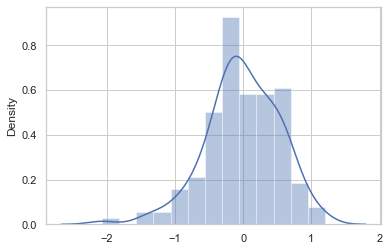

In [538]:
residual = y_test - y_pred
sns.distplot(residual)

In [539]:
abs(residual.mean())

0.007416487467495869

### Inferences
  - The model's means residuals are 0.0074, which indicates it is a good estimator.

### Linearity of variables

Text(0, 0.5, 'y_pred')

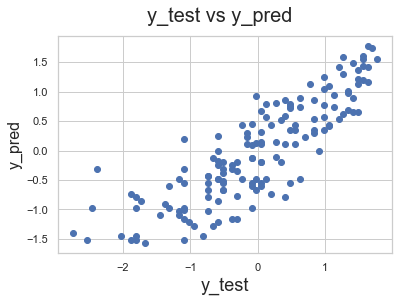

In [540]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)   

### Test for Homoscedasticity

eval_env: 1


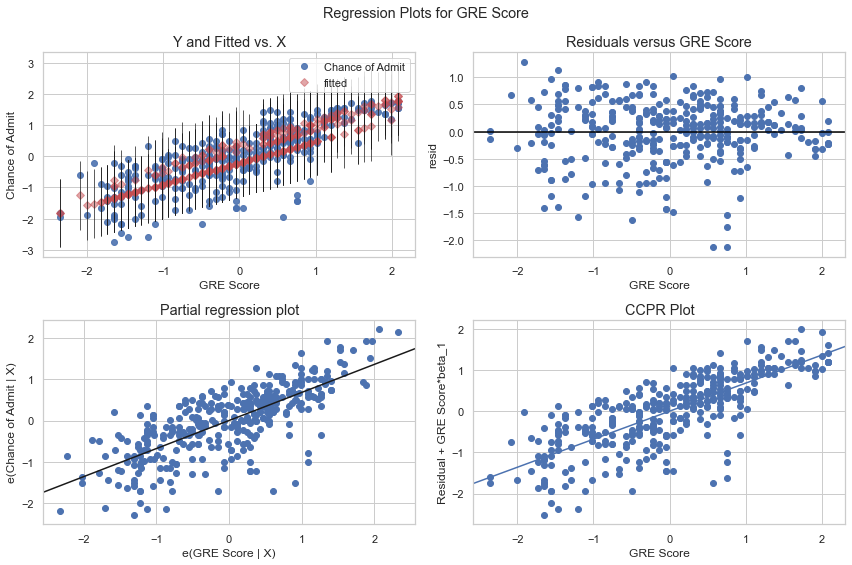

In [569]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(lr_6, 'GRE Score', fig=fig)

### Inferences
- We can see that the points are plotted randomly spread or scattered. points or residuals are scattered around the ‘0’ line, there is no pattern, and points are not based on one side so there’s no problem of heteroscedasticity. 
- With the predictor variable ‘area’ there’s no heteroscedasticity.

<AxesSubplot:>

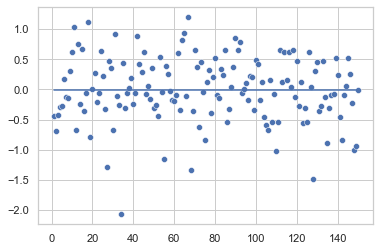

In [541]:
sns.scatterplot(np.arange(1,151,1),residual)
sns.lineplot(np.arange(1,151,1),residual.mean())

### Inferences 

 - they are pretty symmetrically distributed

### Normality of residuals

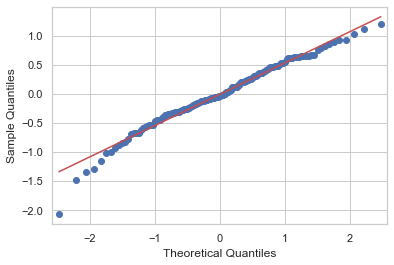

In [542]:
sm.qqplot(residual, line = 's')
plt.show()

### Inferences
 - Data that aligns closely to the dotted line indicates a normal distribution.

## Model Performance Evaluation
 - Metrics checked - 
   - MAE
   - RMSE
   - R2
   - Adj R2
 - Train and Test performances are checked
  

In [543]:
r2 = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error( y_test, y_pred )
rmse = np.sqrt( mean_squared_error( y_test, y_pred ))
mape = mean_absolute_percentage_error(y_test,y_pred)

# initialise data of lists.
perf_data = [[r2],[mae],[mse],[rmse],[mape]]
# Creates pandas DataFrame.
eval_ = pd.DataFrame(perf_data,columns= ["Scores"] ,index = ["R-Squared","Mean Absolute Error","Mean Square Error",
                                                             "Root Mean Square Error","Mean Absolute Percentage Error"])

In [544]:
eval_.head()

,Scores
R-Squared,0.727859
Mean Absolute Error,0.418479
Mean Square Error,0.289148
Root Mean Square Error,0.537725
Mean Absolute Percentage Error,2.008603


### Inference

#### Error term 

An error term appears in a statistical model, like a regression model, to indicate the uncertainty in the model.

 - R-Squared (Accuracy Score) - 0.72
   - This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.As seen above our residual plot looks good, which means we donot have any bias in our model.
   - R-squared does not indicate if a regression model provides an adequate fit to your data. **A good model can have a low R2 value.** On the other hand, a biased model can have a high R2 value
 - Mean Absolute Error - 0.42
   - MAE describes the typical magnitude of the residuals. Small MAE suggests the model is great at prediction, while a large MAE suggests that your model may have trouble in certain areas. There is scope of improvement.
 - Root Mean Square Error - 0.54
   - RMSE is defined as the square root of the average squared difference between the predicted and the actual score. The lower the RMSE, the better a model fits a dataset
   - A huge difference between the RMSE and MAE indicates outliers. A smaller difference indicates less outliers in our case.
 - Mean Square Error - 0.29
   - MSE equation is most apparent with the presence of outliers in our data.
   - While each residual in MAE contributes proportionally to the total error, the error grows quadratically in MSE.This means that outliers in our data will contribute to much higher total error in the MSE than they would the MAE.
 - Mean Absolute Percentage Error - 2%
   - MAPE is biased towards predictions that are systematically less than the actual values themselves.MAPE will be lower when the prediction is lower than the actual compared to a prediction that is higher by the same amount

## Train & Test performances are checked

### Train Performance

In [579]:
y_train_pred = lr_6.predict(X_train_6)

<AxesSubplot:ylabel='Density'>

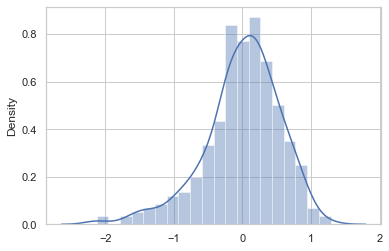

In [580]:
res = y_train - y_train_pred
sns.distplot(res)

### Test Performance

In [545]:
df_pred['Preds'] = y_pred

Text(0.5, 1.0, 'Actual values Vs Predicted values')

<Figure size 2160x1152 with 0 Axes>

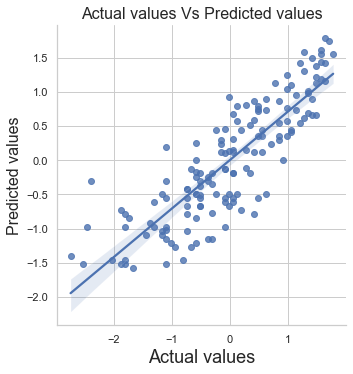

In [563]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure(figsize=(30,16))
sns.lmplot(x='Chance of Admit', y="Preds", data=df_pred)
plt.xlabel('Actual values', fontsize=18)                        
plt.ylabel('Predicted values', fontsize=16)  
plt.title('Actual values Vs Predicted values', fontsize=16)

<AxesSubplot:xlabel='Chance of Admit', ylabel='Density'>

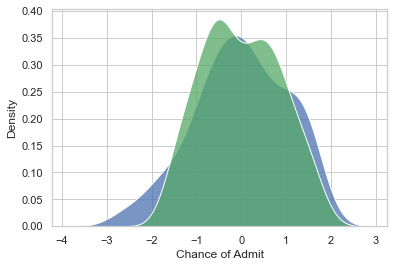

In [564]:
sns.kdeplot(data=df_pred, x='Chance of Admit', color='b', multiple="stack")
sns.kdeplot(data=df_pred, x='Preds', color='g', multiple="stack")

### Inferences 
  - The above kdeplot shows two graphs - the actual (blue) and predicted (green) values for chance of admission. The graphs shows **Model is a good estimator.**

## Conclusions & Recommendations

### Inferences based on EDA

 - Based on the analysis we donot have outliers for independent features like 'GRE Score', 'TOEFL Score' & 'CGPA'.
 - 'Chance of Admit' is slightly left screwed. Since 'Chance of Admit' is a slightly left skewed, we don't have to handle it.
 - Among students who have done research vs those who did not, **56 % said Yes and 44 % said No**
 - More than **50% of the data has a university rating of 3 or 2**
 - A majority of students (56%) have letter of recommendation values between 3.0 and 4.5
 - A **strong positive relationship exists between Chance of admit and numerical variables (GRE & TOEFL score and CGPA).**
 - **GRE Score** , **TOFEL Score** and **CGPA** are highly correlated **(0.80)**. We should drop two of these.
 - Based on the analysis an **upward trend for each categorical variable**. A higher rating or value increases the chance of admission   

### Inferences based on Model

With a low p-value and low VIF, these variables do describe the **Chance of Admit** to a good extent.

Final predictors which can be proposed are

- GRE Score            **(coef : 0.6818, p-value - 0.000, VIF : 1.24)**
- LOR_4.0              **(coef : 0.3803, p-value - 0.000, VIF : 1.22)**
- LOR_4.5              **(coef : 0.5770, p-value - 0.000, VIF : 1.18)**
- LOR_5.0              **(coef : 0.7131, p-value - 0.000, VIF : 1.12)**

We can see that the equation of our best fitted line is:

    $ Chance of Admit = (0.6818 * GRE Score ) + (0.3803 * LOR_4.0) + (0.5770 * LOR_4.5) - (0.7131 *  LOR_5.0) - 0.2157$

**Above equation implies how the "Chance of Admit" with a unit change in any of these predictor variable with all other variables held constant.**

e.g. 
1. The predictor GRE Score suggest that the Chance of Admit increases by a factor of 0.6818 when GRE Score is high.

Overall we have a decent model, still there are area of improvements.

<table style="width:50%">
<tr>
<th>Adj. R-squared</th>
<th>r2_score</th>
<th>Prob (F-statistic)</th>
<th>AIC</th>
<th>BIC</th>
<th>RMSE</th>
</tr>

<tr>
<td>0.693</td>
<td>0.696</td>
<td>620e-88</td>
<th>586</th>
<th>605</th>
<th>0.54</th>
</tr>
</table>

#### Note - We found that TOEFL and CGPA are highly correlated with GRE scores, hence these variables can also be used in exchange for GRE scores.

### Possible Model Improvement Areas

We have a couple of options:

1. Add new features GRE_TOEFL_CGPA_Ratio = (GRE & TOEFL Score & CGPA ratio) etc.
2. Removing outliers or handling outlier by minmax distribution.
3. Build a non-linear model


### Suggestions

#### Jamboree Education - Can use the above model to enhance newly launched feature where students/learners can come to their website and check their probability of getting into the IVY league college.

**Key features which influence the chance of Admit are**
 - GRE Score
 - TOEFL Score
 - CGPA
 - LOR greater or equal to than 4.5
 
 #### A higher University rating will increases the chance of admission
 
 #### A higher value of LOR and SPO will also increases the chance of admission for the student.